# Gradient descent

## Imports & Utils

In [1]:
import importlib

import jax
jax.config.update("jax_platform_name", "cpu")

from copy import deepcopy
import equinox as eqx
from functools import partial
from jax import jit, lax, value_and_grad
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from sbmltoodejax.biomodels_api import get_content_for_model
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

In [2]:
def generate_model(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12):
    model_fp = "jax_model.py"
    model_xml_body = get_content_for_model(model_idx)
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(model_data, model_fp, deltaT=deltaT, atol=atol, rtol=rtol)
    
    return model_fp

def load_model(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12):
    model_fp = generate_model(model_idx, deltaT=deltaT, atol=atol, rtol=rtol)
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_fp)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, "ModelRollout")
    model = model_cls()
    y0 = getattr(module, "y0")
    w0 = getattr(module, "w0")
    c = getattr(module, "c")

    return model, y0, w0, c

In [3]:
def sine_wave(t, A=1, w=.1, phi=10., b=2):
    return A*jnp.sin(2*jnp.pi*w*t+phi) + b

In [4]:
# plot utils
default_colors = [(204,121,167), 
                  (0,114,178),
                  (230,159,0),  
                  (0,158,115),
                  (127,127,127),
                  (240,228,66),
                  (148,103,189),
                  (86,180,233),
                  (213,94,0),
                  (140,86,75),
                  (214,39,40),
                  (0,0,0)]
default_colors = [tuple([c/255 for c in color]) for color in default_colors]

## Default Simulation

In [5]:
model_idx = 145
deltaT = 0.1
t0 = 0.
n_secs = 50
n_steps = int(n_secs/deltaT)

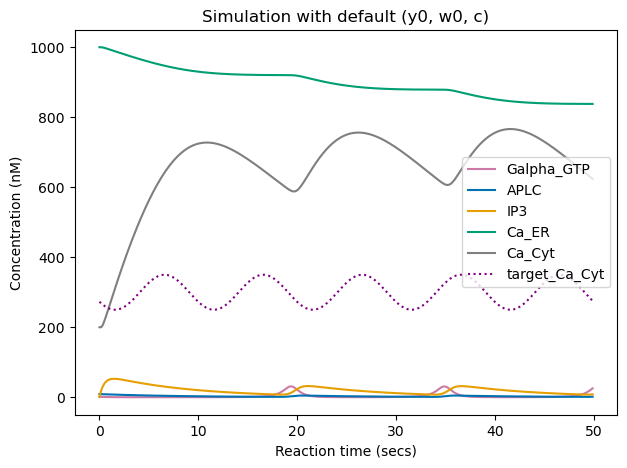

In [6]:
model, y0, w0, c = load_model(model_idx)
y_indexes = model.modelstepfunc.y_indexes
default_ys, default_ws, ts = model(n_steps, y0, w0, c, t0)

target_Ca_Cyt = sine_wave(ts, A=50, w=.1, phi=10., b=300)

plt.figure(figsize=(7,5))
for y_label, y_idx in y_indexes.items():
    plt.plot(ts, default_ys[y_idx], label=y_label, color=default_colors[y_idx])
plt.plot(ts, target_Ca_Cyt, label="target_Ca_Cyt", linestyle=":", color="purple")
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.title("Simulation with default (y0, w0, c)")
plt.legend()
plt.show()

## Optimization of kinematic parameters *c*

In [7]:
@jit
def grad_loss(c, model):
    ys, ws, ts = model(n_steps, y0, w0, c, t0)
    loss = jnp.sqrt(jnp.square(ys[y_indexes["Ca_Cyt"]] - target_Ca_Cyt).sum())
    return loss


@jit
def make_step(c, model, opt_state):
    loss, grads = value_and_grad(grad_loss)(c, model)
    updates, opt_state = optim.update(grads, opt_state)
    c = optax.apply_updates(c, updates)
    return loss, c, opt_state

In [8]:
model, y0, w0, c = load_model(model_idx)

n_optim_steps = 1000
optim = optax.adam(1e-3)
opt_state = optim.init(c)
train_loss = []
for optim_step_idx in range(n_optim_steps):
    loss, c, opt_state = make_step(c, model, opt_state)
    train_loss.append(loss)
    
    
# re-run simulation with optimized c
ys, ws, ts = model(n_steps, y0, w0, c, t0)

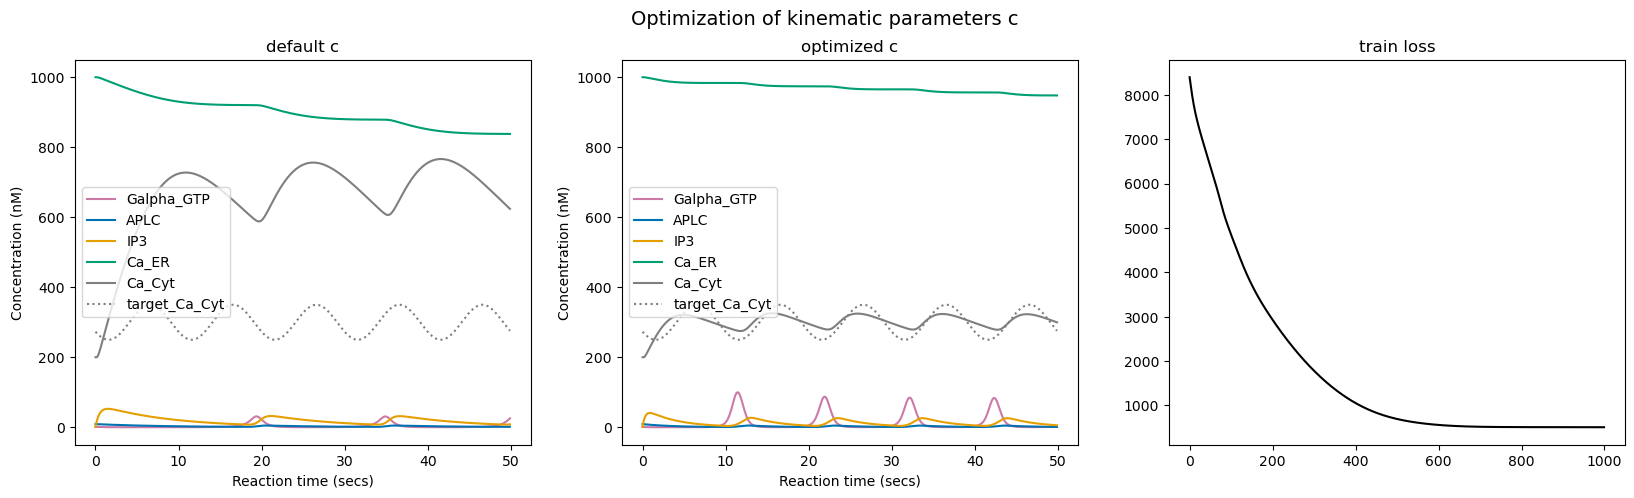

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

for y_label, y_idx in y_indexes.items():
    ax[0].plot(ts, default_ys[y_idx], label=y_label, color=default_colors[y_idx])
    ax[1].plot(ts, ys[y_idx], label=y_label, color=default_colors[y_idx])
    
for i in range(2):
    ax[i].plot(ts, target_Ca_Cyt, label="target_Ca_Cyt", linestyle=":", color=default_colors[y_indexes["Ca_Cyt"]])
    ax[i].set_xlabel("Reaction time (secs)")
    ax[i].set_ylabel("Concentration (nM)")
    ax[i].legend()
    
ax[2].plot(train_loss, color=default_colors[-1])
    
ax[0].set_title("default c")
ax[1].set_title("optimized c")
ax[2].set_title("train loss")

fig.suptitle("Optimization of kinematic parameters c", fontsize=14)

plt.show()

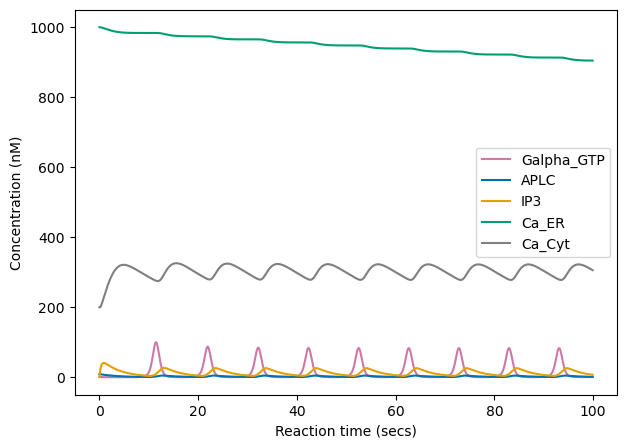

In [11]:
# longer rollout
long_ys, long_ws, long_ts = model(n_steps*2, y0, w0, c, t0)

plt.figure(figsize=(7,5))
for y_label, y_idx in y_indexes.items():
    plt.plot(long_ts, long_ys[y_idx], label=y_label, color=default_colors[y_idx])
plt.legend()
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.show()

## Optimization by intervention on *y* dynamical states

In [12]:
class ModelRolloutWithIntervention(eqx.Module):
    deltaT: float = eqx.static_field()
    modelstep_fn: eqx.Module

    def __init__(self, deltaT, modelstep_fn):

        self.deltaT = deltaT
        self.modelstep_fn = modelstep_fn

    @partial(jit, static_argnames=("n_steps",))
    def __call__(self, n_steps, y0, w0, c, t0, intervention_ts, intervention_ys):

        @jit
        def f(carry, x):
            y, w, c, t = carry
            y, w, c, t = self.modelstep_fn(y, w, c, t, self.deltaT)
            
            # Add intervention
            interval_idx = self.time_to_interval(t, intervention_ts)
            y = lax.cond((interval_idx + 1).sum() > 0, self.apply_intervention, self.apply_null, y, intervention_ys, interval_idx)
            
            return (y, w, c, t), (y, w, t)
        (y, w, c, t), (ys, ws, ts) = lax.scan(f, (y0, w0, c, t0), jnp.arange(n_steps))
        ys = jnp.moveaxis(ys, 0, -1)
        ws = jnp.moveaxis(ws, 0, -1)
        return ys, ws, ts

    @jit
    def time_to_interval(self, t, intervention_ts):
        """
        returns -1 if t not in intervention_ts, else return corresponding interval
        """
        return jnp.where((t - intervention_ts) < deltaT / 10, size=1, fill_value=-1)[0][0]
    
    @jit
    def apply_intervention(self, y, intervention_ys, interval_idx):
        for y_idx in intervention_ys.keys():
            y = y.at[y_idx].set(intervention_ys[y_idx][interval_idx])
        return y
    
    @jit
    def apply_null(self, y, intervention_ys, interval_idx=-1):
        return y

In [13]:
@eqx.filter_jit
def grad_loss(intervention_ys, model):
    ys, ws, ts = model(n_steps, y0, w0, c, t0, intervention_ts, intervention_ys)
    loss = jnp.sqrt(jnp.square(ys[y_indexes["Ca_Cyt"]] - target_Ca_Cyt).sum())
    return loss


@eqx.filter_jit
def make_step(intervention_ys, model, opt_state):
    loss, grads = value_and_grad(grad_loss)(intervention_ys, model)
    updates, opt_state = optim.update(grads, opt_state)
    intervention_ys = optax.apply_updates(intervention_ys, updates)
    return loss, intervention_ys, opt_state

In [14]:
model, y0, w0, c = load_model(model_idx)
model = ModelRolloutWithIntervention(deltaT, model.modelstepfunc)
n_optim_steps = 3000
optim = optax.adam(1e-2)

In [15]:
intervention_ts = deepcopy(ts)

intervention_ys_init_1 = {y_indexes["Galpha_GTP"]: deepcopy(default_ys[y_indexes["Galpha_GTP"]]), 
                          y_indexes["IP3"]:  deepcopy(default_ys[y_indexes["IP3"]])}
ys_1, _, _ = model(n_steps, y0, w0, c, t0, intervention_ts, intervention_ys_init_1)

intervention_ys_init_2 = {y_indexes["Galpha_GTP"]: sine_wave(intervention_ts, A=10, w=.1, phi=0., b=50),
                          y_indexes["IP3"]: sine_wave(intervention_ts, A=10, w=.1, phi=0., b=5)}
ys_2, _, _ = model(n_steps, y0, w0, c, t0, intervention_ts, intervention_ys_init_2)

In [16]:
# Optim from init 1
intervention_ys = deepcopy(intervention_ys_init_1)
opt_state = optim.init(intervention_ys)
train_loss_1 = []

for optim_step_idx in range(n_optim_steps):
    loss, intervention_ys, opt_state = make_step(intervention_ys, model, opt_state)
    train_loss_1.append(loss)
    
optimized_ys_1, _, _ = model(n_steps, y0, w0, c, t0, intervention_ts, intervention_ys)

In [17]:
# Optim from init 2
intervention_ys = deepcopy(intervention_ys_init_2)
opt_state = optim.init(intervention_ys)
train_loss_2 = []

for optim_step_idx in range(n_optim_steps):
    loss, intervention_ys, opt_state = make_step(intervention_ys, model, opt_state)
    train_loss_2.append(loss)
    
optimized_ys_2, _, _ = model(n_steps, y0, w0, c, t0, intervention_ts, intervention_ys)

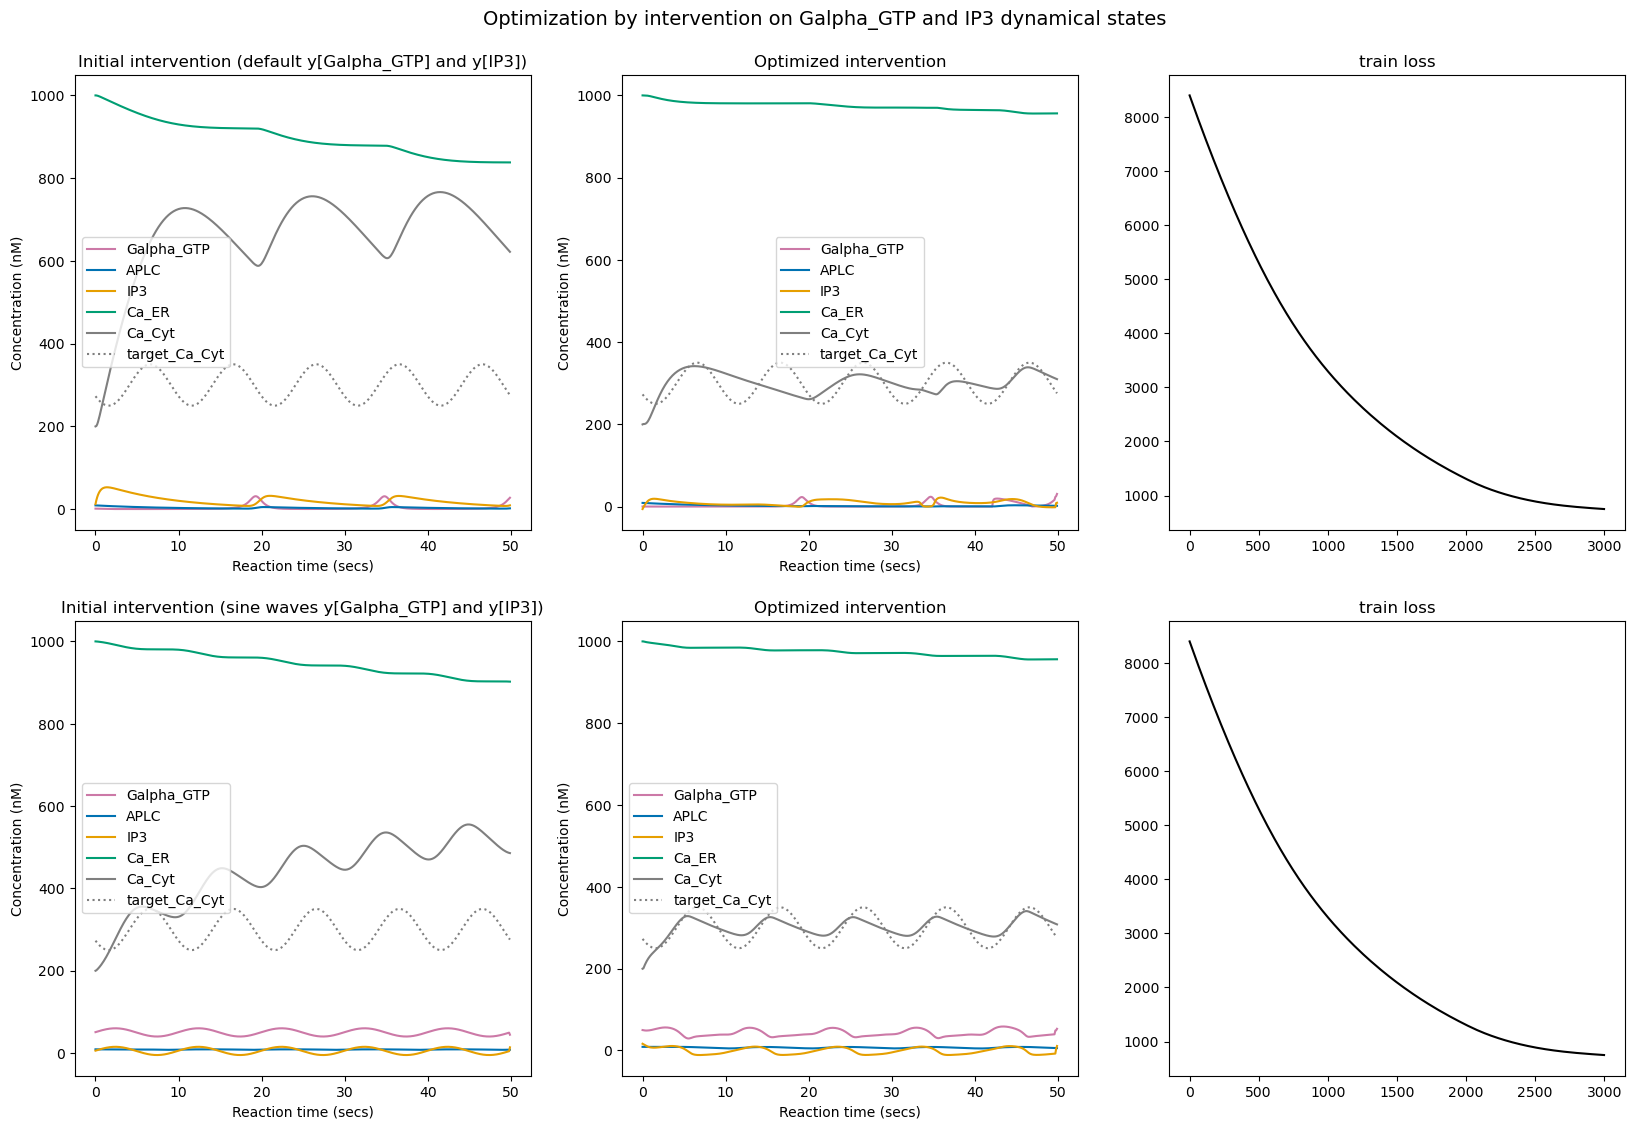

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(20,13))

for y_label, y_idx in y_indexes.items():
    ax[0, 0].plot(ts, ys_1[y_idx], label=y_label, color=default_colors[y_idx])
    ax[0, 1].plot(ts, optimized_ys_1[y_idx], label=y_label, color=default_colors[y_idx])
    ax[1, 0].plot(ts, ys_2[y_idx], label=y_label, color=default_colors[y_idx])
    ax[1, 1].plot(ts, optimized_ys_2[y_idx], label=y_label, color=default_colors[y_idx])
    
for i in range(2):
    for j in range(2):
        ax[i, j].plot(ts, target_Ca_Cyt, label="target_Ca_Cyt", linestyle=":", color=default_colors[y_indexes["Ca_Cyt"]])
        ax[i, j].set_xlabel("Reaction time (secs)")
        ax[i, j].set_ylabel("Concentration (nM)")
        ax[i, j].legend()
    
    ax[i, 2].plot(train_loss_1, color=default_colors[-1])

ax[0, 0].set_title("Initial intervention (default y[Galpha_GTP] and y[IP3])")
ax[0, 1].set_title("Optimized intervention")
ax[0, 2].set_title("train loss")
ax[1, 0].set_title("Initial intervention (sine waves y[Galpha_GTP] and y[IP3])")
ax[1, 1].set_title("Optimized intervention")
ax[1, 2].set_title("train loss")

fig.suptitle("Optimization by intervention on Galpha_GTP and IP3 dynamical states", y=0.93, fontsize=14)
plt.show()

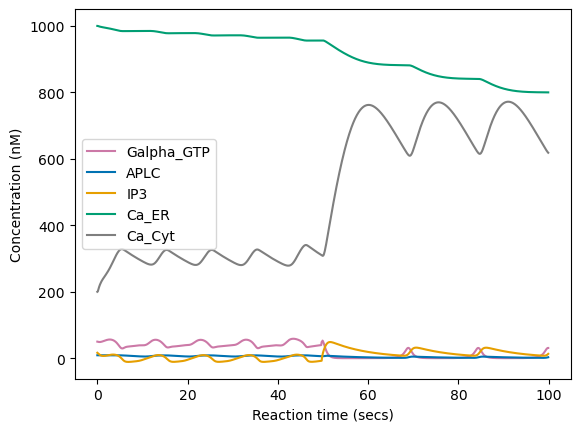

In [19]:
fig = plt.figure()

long_optimized_ys_2, _, _ = model(n_steps*2, y0, w0, c, t0, intervention_ts, intervention_ys)
for y_label, y_idx in y_indexes.items():
    plt.plot(long_ts, long_optimized_ys_2[y_idx], label=y_label, color=default_colors[y_idx])
    
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.legend()
plt.show()

## Limitations
* long
* Nan Values
* A lot of local minimas
* Signal not always very good (recurrence+solver)